# Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
from tensorflow.keras.models import load_model

# Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
target_dir = "/content/drive/MyDrive/data/varsity/"
os.makedirs(target_dir, exist_ok=True)

In [ ]:
# sir uncomment it to download
# !wget https://raw.githubusercontent.com/yiminghzc/MDST-GNN/main/MDST-GNN/data/traffic.txt.gz -P /content/drive/MyDrive/data/varsity/

In [ ]:
file_path = '/content/drive/MyDrive/data/varsity/traffic.txt.gz'
df = pd.read_csv(file_path, compression='gzip', header=None)

# EDA

The dataset contains electricity consumption (in kWh) from 321 clients (nodes), recorded every 15 minutes

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Columns: 862 entries, 0 to 861
dtypes: float64(862)
memory usage: 115.4 MB


In [ ]:
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,852,853,854,855,856,857,858,859,860,861
0,0.0048,0.0146,0.0289,0.0142,0.0064,0.0232,0.0162,0.0242,0.0341,0.0375,...,0.0051,0.0051,0.0074,0.0079,0.0051,0.0051,0.0339,0.0051,0.0100,0.0121
1,0.0072,0.0148,0.0350,0.0174,0.0084,0.0240,0.0201,0.0338,0.0434,0.0381,...,0.0036,0.0036,0.0107,0.0058,0.0036,0.0036,0.0348,0.0036,0.0087,0.0136
2,0.0040,0.0101,0.0267,0.0124,0.0049,0.0170,0.0127,0.0255,0.0332,0.0309,...,0.0030,0.0030,0.0043,0.0050,0.0030,0.0030,0.0327,0.0030,0.0061,0.0107
3,0.0039,0.0060,0.0218,0.0090,0.0029,0.0118,0.0088,0.0163,0.0211,0.0199,...,0.0033,0.0033,0.0019,0.0052,0.0033,0.0033,0.0292,0.0033,0.0040,0.0071
4,0.0042,0.0055,0.0191,0.0082,0.0024,0.0095,0.0064,0.0087,0.0144,0.0226,...,0.0049,0.0049,0.0011,0.0071,0.0049,0.0049,0.0264,0.0049,0.0040,0.0039


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,17544.0,0.049324,0.062469,0.0,0.008900,0.0463,0.0599,0.4747
1,17544.0,0.046016,0.048398,0.0,0.018100,0.0368,0.0537,0.4500
2,17544.0,0.105870,0.082205,0.0,0.035600,0.0810,0.1755,0.4201
3,17544.0,0.056633,0.036746,0.0,0.026800,0.0600,0.0747,0.4947
4,17544.0,0.026812,0.035872,0.0,0.007875,0.0190,0.0243,0.4069
...,...,...,...,...,...,...,...,...
857,17544.0,0.025883,0.016802,0.0,0.010700,0.0287,0.0372,0.3975
858,17544.0,0.039669,0.018035,0.0,0.027600,0.0421,0.0540,0.1419
859,17544.0,0.043058,0.023567,0.0,0.027800,0.0412,0.0638,0.3532
860,17544.0,0.029241,0.017606,0.0,0.014100,0.0318,0.0393,0.4159


In [ ]:
24*60/5

288.0

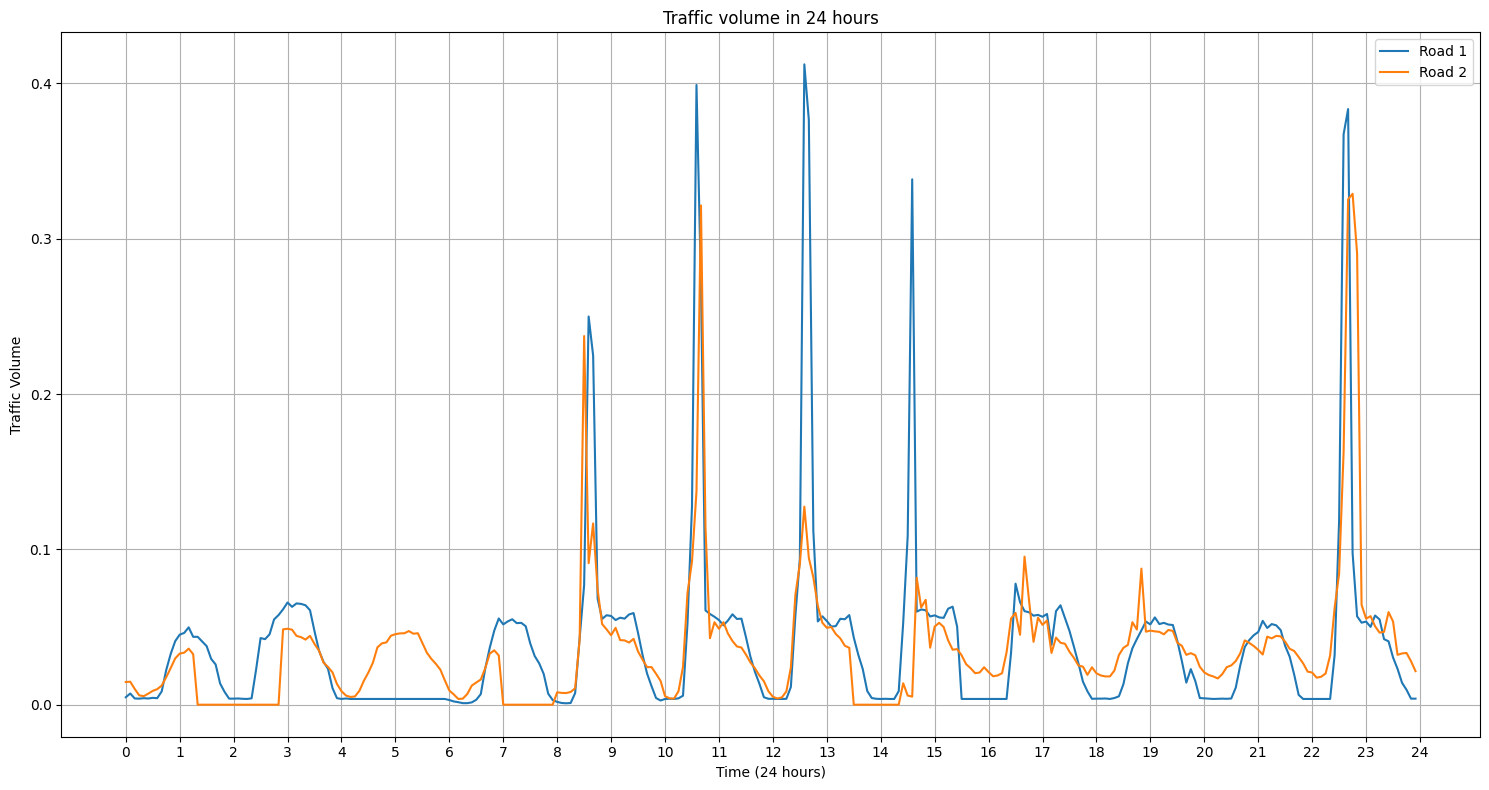

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(df.iloc[:288, 0])
plt.plot(df.iloc[:288, 1])
plt.title('Traffic volume in 24 hours')
plt.xlabel('Time (24 hours)')
plt.ylabel('Traffic Volume')
plt.grid(True)
plt.xticks(np.arange(0, 289, 12), np.arange(0, 25, 1))
plt.legend(['Road 1', 'Road 2'])
plt.tight_layout()
plt.show()


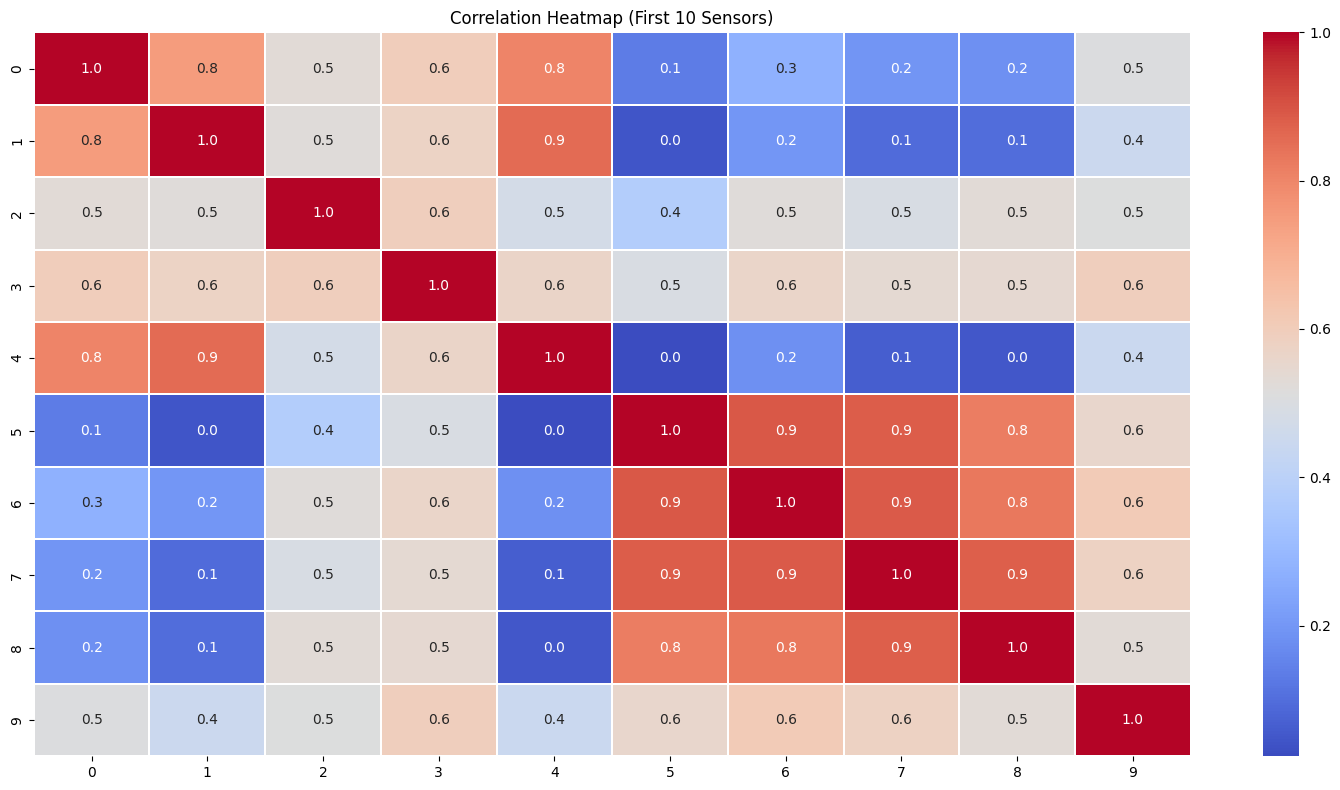

In [ ]:
correlation_subset = df.iloc[:, :10].corr()
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_subset, annot=True, cmap='coolwarm', linewidths=0.2, fmt='.1f')
plt.title('Correlation Heatmap (First 10 Sensors)')
plt.tight_layout()
plt.show()


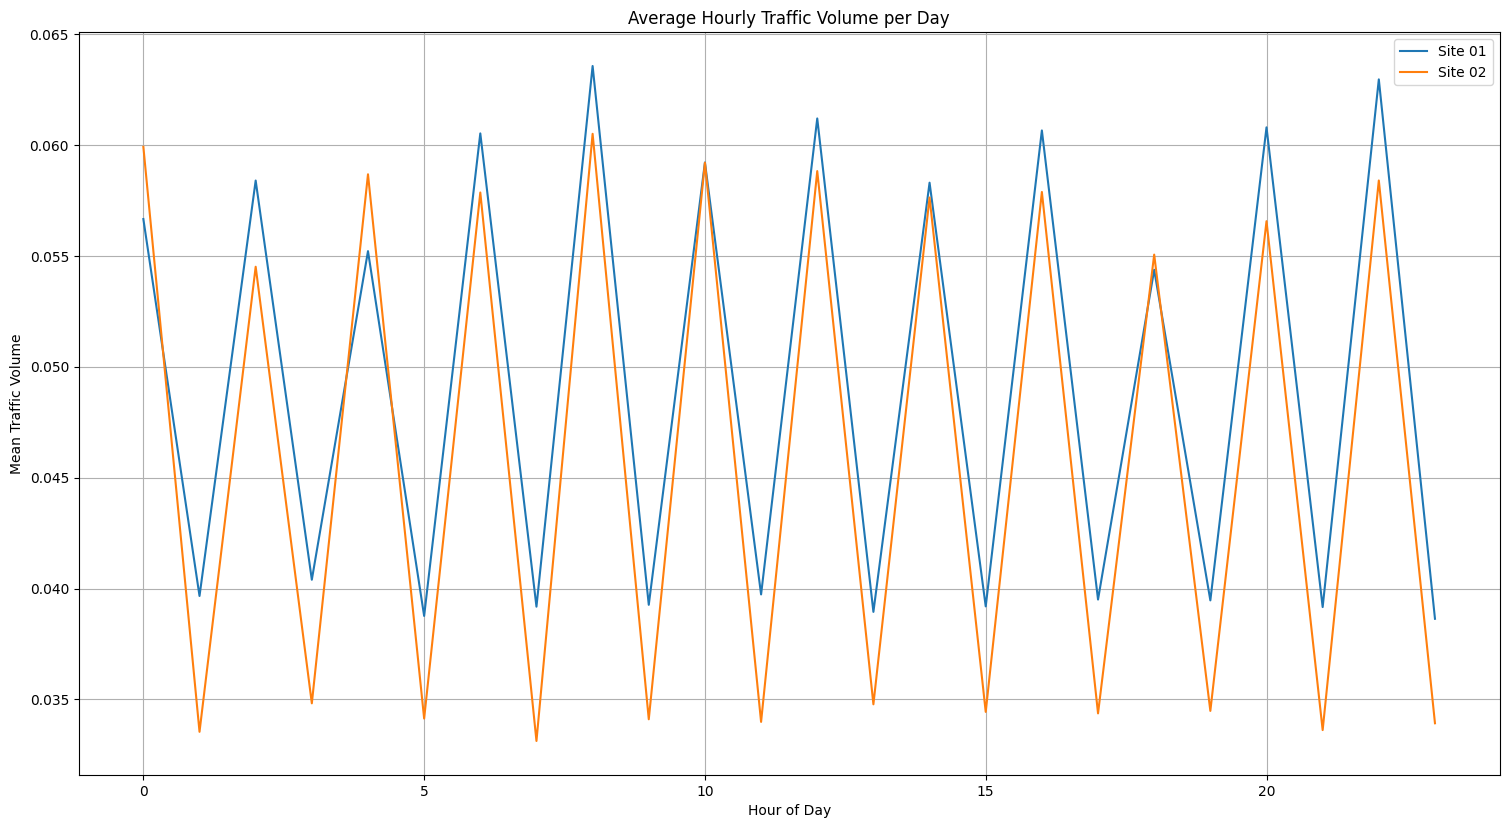

In [ ]:
df['hours'] = (df.index % 288) // 12

plt.figure(figsize=(15, 8))
plt.plot(df.groupby('hours')[[0,1]].mean())
plt.grid(True)
plt.tight_layout()
plt.xlabel('Hour of Day')
plt.ylabel('Mean Traffic Volume')
plt.title('Average Hourly Traffic Volume per Day')
plt.legend(['Site 01', 'Site 02'])
plt.show()


In [ ]:
date_range = pd.date_range(start='2015-01-01', periods=len(df), freq='5min')
df['month'] = date_range.month

In [ ]:
df.drop(columns='hours').groupby('month')[[0,1,2]].mean()

,0,1,2
month,,,
1,0.047980,0.046711,0.104251
2,0.051011,0.045899,0.107832
3,0.046430,0.036480,0.103387


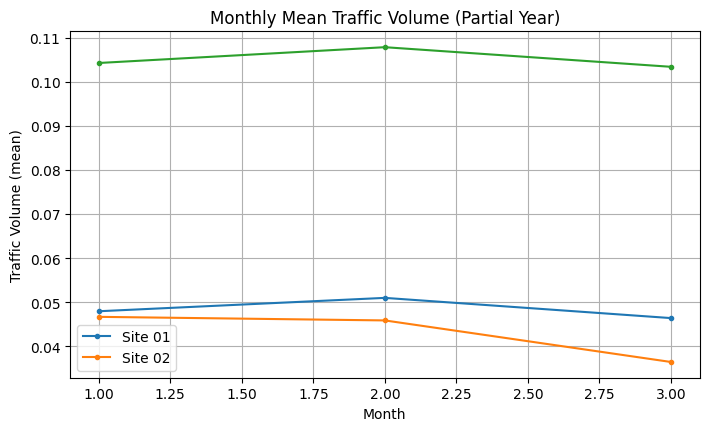

In [ ]:
monthly_avg = df.drop(columns='hours').groupby('month')[[0,1,2]].mean()

plt.figure(figsize=(7, 4))
plt.plot(monthly_avg, marker='.')
plt.grid(True)
plt.tight_layout()
plt.xlabel('Month')
plt.ylabel('Traffic Volume (mean)')
plt.title('Monthly Mean Traffic Volume (Partial Year)')
plt.legend(['Site 01', 'Site 02'])
plt.show()


In [ ]:
sample_sensors = df.columns[:2]
# df[sample_sensors].iloc[:1000].plot(figsize=(15, 6))
# plt.title('Traffic Volume for Sample Sensors (First 1000 steps)')
# plt.show()


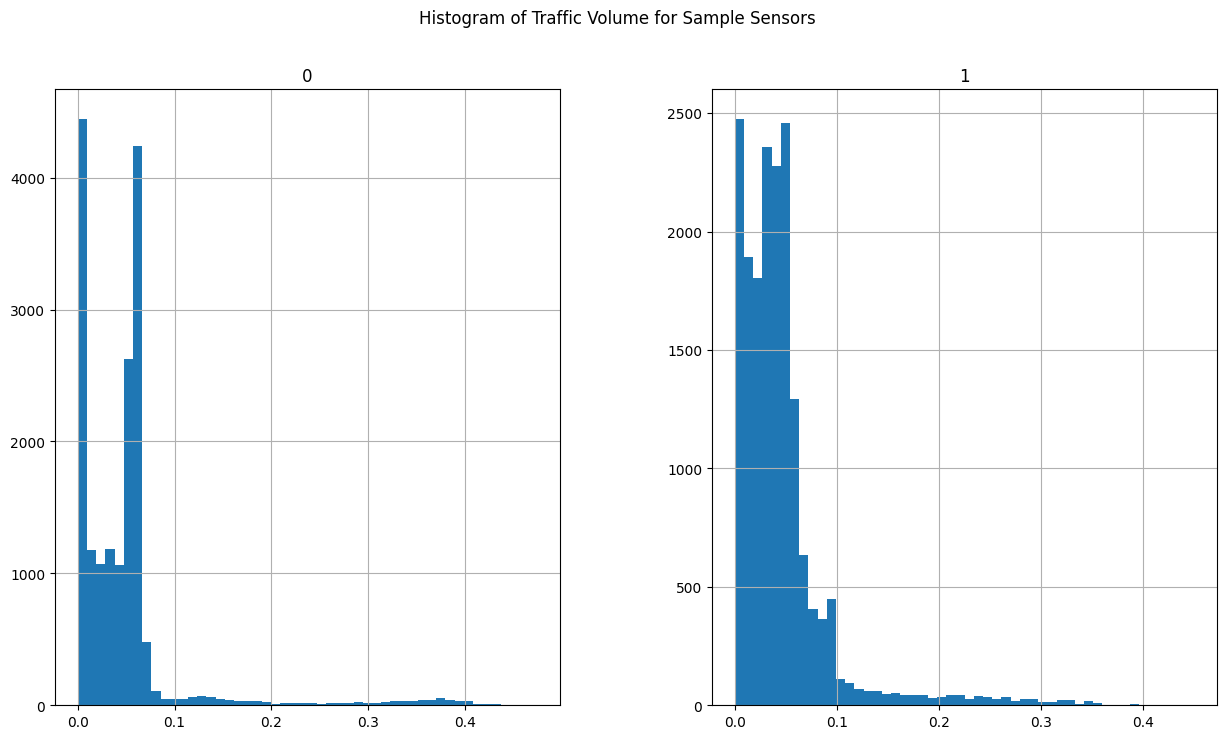

In [ ]:
df[sample_sensors].hist(bins=50, figsize=(15, 8))
plt.suptitle('Histogram of Traffic Volume for Sample Sensors')
plt.show()


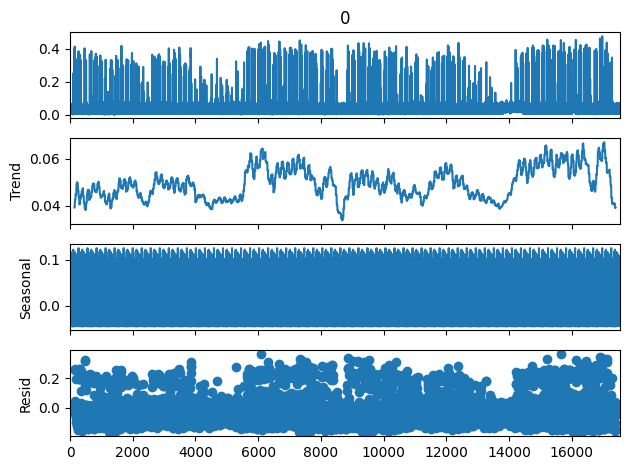

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

rolling_mean = df[sample_sensors].rolling(window=288).mean()
rolling_std = df[sample_sensors].rolling(window=288).std()

result = seasonal_decompose(df[sample_sensors[0]], model='additive', period=288)
result.plot()
plt.show()


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,17544.0,0.049324,0.062469,0.0,0.008900,0.0463,0.0599,0.4747
1,17544.0,0.046016,0.048398,0.0,0.018100,0.0368,0.0537,0.4500
2,17544.0,0.105870,0.082205,0.0,0.035600,0.0810,0.1755,0.4201
3,17544.0,0.056633,0.036746,0.0,0.026800,0.0600,0.0747,0.4947
4,17544.0,0.026812,0.035872,0.0,0.007875,0.0190,0.0243,0.4069
...,...,...,...,...,...,...,...,...
859,17544.0,0.043058,0.023567,0.0,0.027800,0.0412,0.0638,0.3532
860,17544.0,0.029241,0.017606,0.0,0.014100,0.0318,0.0393,0.4159
861,17544.0,0.031537,0.019453,0.0,0.012500,0.0341,0.0467,0.2174
hours,17544.0,11.484952,6.915117,0.0,5.000000,11.0000,17.0000,23.0000


In [ ]:
df.drop(columns=['hours', 'month'], inplace=True)

# Preprocess

In [ ]:
# Time split FIRST
split_ratio = 0.7
split_idx = int(len(df) * split_ratio)

df_train_raw = df.iloc[:split_idx]
df_test_raw  = df.iloc[split_idx:]

In [ ]:
df_train = df_train_raw.copy()
df_test = df_test_raw.copy()

In [ ]:
12*60/5

144.0

In [ ]:
144*5/60

12.0

In [ ]:
24*5/60

2.0

In [ ]:
window_size = 168
forecast_horizon = 24   # 2 hours = 24 * 5min
batch_size = 24
n_nodes = df_train.shape[1]
n_nodes

862

In [ ]:
def dataset_generator(df, win_size, horizon):
    length = len(df) - win_size - horizon
    for i in range(length):
        x = df.iloc[i:i+win_size].values.astype(np.float32)
        y = df.iloc[i+win_size:i+win_size+horizon].values.astype(np.float32)
        yield x, y

def create_tf_dataset(df, win_size, horizon, batch_size):
    output_signature = (
        tf.TensorSpec(shape=(win_size, df.shape[1]), dtype=tf.float32),
        tf.TensorSpec(shape=(horizon, df.shape[1]), dtype=tf.float32),
    )
    ds = tf.data.Dataset.from_generator(
        lambda: dataset_generator(df, win_size, horizon),
        output_signature=output_signature
    )
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset = create_tf_dataset(df_train, window_size, forecast_horizon, batch_size)
test_dataset = create_tf_dataset(df_test, window_size, forecast_horizon, batch_size)

# Model: PatchedTalNet

In [ ]:
import tensorflow as tf
import zipfile
import os

In [ ]:
@tf.keras.utils.register_keras_serializable()
class RevIN(tf.keras.layers.Layer):
    def __init__(self, eps=1e-5, affine=True, **kwargs):
        super().__init__(**kwargs)
        self.eps = eps
        self.affine = affine

    def build(self, input_shape):
        n = int(input_shape[-1])
        if self.affine:
            self.gamma = self.add_weight(
                name="gamma", shape=(1, 1, n),
                initializer="ones", trainable=True
            )
            self.beta = self.add_weight(
                name="beta", shape=(1, 1, n),
                initializer="zeros", trainable=True
            )
        super().build(input_shape)

    def call(self, x, mode, stats=None):
        if mode == "norm":
            mu = tf.reduce_mean(x, axis=1, keepdims=True)
            sigma = tf.math.reduce_std(x, axis=1, keepdims=True)
            x_hat = (x - mu) / (sigma + self.eps)
            if self.affine:
                x_hat = x_hat * self.gamma + self.beta
            return x_hat, (mu, sigma)

        elif mode == "denorm":
            mu, sigma = stats
            x_hat = x
            if self.affine:
                x_hat = (x_hat - self.beta) / (self.gamma + self.eps)
            return x_hat * (sigma + self.eps) + mu

    def get_config(self):
        config = super().get_config()
        config.update({
            "eps": self.eps,
            "affine": self.affine
        })
        return config

In [ ]:
@tf.keras.utils.register_keras_serializable()
class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self, patch_len=16, stride=8, d_model=128, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.patch_len = patch_len
        self.stride = stride
        self.d_model = d_model
        self.dropout_rate = dropout

        self.dropout = tf.keras.layers.Dropout(dropout)
        self.proj = tf.keras.layers.Dense(d_model)
        self.pos_emb = None

    def build(self, input_shape):
        T = int(input_shape[1])
        n_patches = 1 + (T - self.patch_len) // self.stride

        self.pos_emb = self.add_weight(
            name="pos_emb",
            shape=(1, n_patches, self.d_model),
            initializer="random_normal",
            trainable=True,
        )
        super().build(input_shape)

    def call(self, x, training=None):
        patches = tf.signal.frame(
            x, frame_length=self.patch_len,
            frame_step=self.stride,
            axis=1
        )

        B = tf.shape(patches)[0]
        n_patches = tf.shape(patches)[1]
        N = tf.shape(patches)[3]

        patches = tf.reshape(patches, [B, n_patches, self.patch_len * N])
        tokens = self.proj(patches)
        tokens = tokens + self.pos_emb
        tokens = self.dropout(tokens, training=training)
        return tokens

    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_len": self.patch_len,
            "stride": self.stride,
            "d_model": self.d_model,
            "dropout": self.dropout_rate
        })
        return config

In [ ]:
@tf.keras.utils.register_keras_serializable()
class PatchedTalNet(tf.keras.Model):
    def __init__(self, n_nodes, horizon,
                 patch_len=16, patch_stride=8,
                 d_model=128, n_heads=8, n_stack=2,
                 dropout_rate=0.2,
                 pool_lstm_units=None,
                 **kwargs):
        super().__init__(**kwargs)

        self.n_nodes = n_nodes
        self.horizon = horizon
        self.patch_len = patch_len
        self.patch_stride = patch_stride
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_stack = n_stack
        self.dropout_rate = dropout_rate
        self.pool_lstm_units = pool_lstm_units

        self.revin = RevIN()

        self.patch = PatchEmbedding(
            patch_len=patch_len,
            stride=patch_stride,
            d_model=d_model,
            dropout=dropout_rate,
            name="patch_embedding"
        )

        key_dim = max(8, d_model // n_heads)

        self.blocks = []
        for _ in range(n_stack):
            self.blocks.append({
                "attn": tf.keras.layers.MultiHeadAttention(
                    num_heads=n_heads,
                    key_dim=key_dim,
                    dropout=dropout_rate
                ),
                "drop1": tf.keras.layers.Dropout(dropout_rate),
                "add1": tf.keras.layers.Add(),
                "norm1": tf.keras.layers.LayerNormalization(),
                "ffn": tf.keras.Sequential([
                    tf.keras.layers.Dense(4 * d_model, activation="relu"),
                    tf.keras.layers.Dropout(dropout_rate),
                    tf.keras.layers.Dense(d_model),
                ]),
                "drop2": tf.keras.layers.Dropout(dropout_rate),
                "add2": tf.keras.layers.Add(),
                "norm2": tf.keras.layers.LayerNormalization(),
            })

        units = pool_lstm_units if pool_lstm_units else (d_model // 2)

        self.pool = tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(
                units,
                return_sequences=False,
                dropout=dropout_rate * 0.7
            )
        )

        self.out_drop = tf.keras.layers.Dropout(dropout_rate)
        self.fc = tf.keras.layers.Dense(horizon * n_nodes)

    def call(self, x, training=None):

        x, stats = self.revin(x, mode="norm")
        h = self.patch(x, training=training)

        for b in self.blocks:
            attn = b["attn"](h, h, training=training)
            attn = b["drop1"](attn, training=training)
            h = b["add1"]([h, attn])
            h = b["norm1"](h)

            ffn = b["ffn"](h, training=training)
            ffn = b["drop2"](ffn, training=training)
            h = b["add2"]([h, ffn])
            h = b["norm2"](h)

        # Moved outside loop (important!)
        z = self.pool(h, training=training)
        z = self.out_drop(z, training=training)

        y = self.fc(z)
        y = tf.reshape(y, [-1, self.horizon, self.n_nodes])
        y = self.revin(y, mode="denorm", stats=stats)

        return y

    def get_config(self):
        config = super().get_config()
        config.update({
            "n_nodes": self.n_nodes,
            "horizon": self.horizon,
            "patch_len": self.patch_len,
            "patch_stride": self.patch_stride,
            "d_model": self.d_model,
            "n_heads": self.n_heads,
            "n_stack": self.n_stack,
            "dropout_rate": self.dropout_rate,
            "pool_lstm_units": self.pool_lstm_units,
        })
        return config

In [ ]:
model = PatchedTalNet(
    n_nodes=n_nodes,
    horizon=forecast_horizon,
    patch_len=16,
    patch_stride=8,
    d_model=64,
    n_heads=4,
    n_stack=2,
    dropout_rate=0.2
)

model.compile(
    optimizer = tf.keras.optimizers.Adam(
    learning_rate=3e-4,
    clipnorm=1.0),
    # loss="mse",
    loss = tf.keras.losses.Huber(delta=1.0),
    metrics=["mae"]
)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mae',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
504/504 ━━━━━━━━━━━━━━━━━━━━ 41s 62ms/step - loss: 0.0011 - mae: 0.0315 - val_loss: 0.0011 - val_mae: 0.0302
Epoch 2/100
504/504 ━━━━━━━━━━━━━━━━━━━━ 31s 61ms/step - loss: 8.6255e-04 - mae: 0.0266 - val_loss: 7.9518e-04 - val_mae: 0.0243
Epoch 3/100
504/504 ━━━━━━━━━━━━━━━━━━━━ 44s 67ms/step - loss: 6.7812e-04 - mae: 0.0225 - val_loss: 6.9819e-04 - val_mae: 0.0222
Epoch 4/100
504/504 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - loss: 5.9828e-04 - mae: 0.0207 - val_loss: 6.1159e-04 - val_mae: 0.0203
Epoch 5/100
504/504 ━━━━━━━━━━━━━━━━━━━━ 33s 66ms/step - loss: 5.2576e-04 - mae: 0.0191 - val_loss: 5.4135e-04 - val_mae: 0.0186
Epoch 6/100
504/504 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - loss: 4.7203e-04 - mae: 0.0179 - val_loss: 5.0022e-04 - val_mae: 0.0175
Epoch 7/100
504/504 ━━━━━━━━━━━━━━━━━━━━ 31s 62ms/step - loss: 4.3910e-04 - mae: 0.0172 - val_loss: 4.7440e-04 - val_mae: 0.0168
Epoch 8/100
504/504 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - loss: 4.1872e-04 - mae: 0.0167 - val_loss: 4.560

# Evaluation

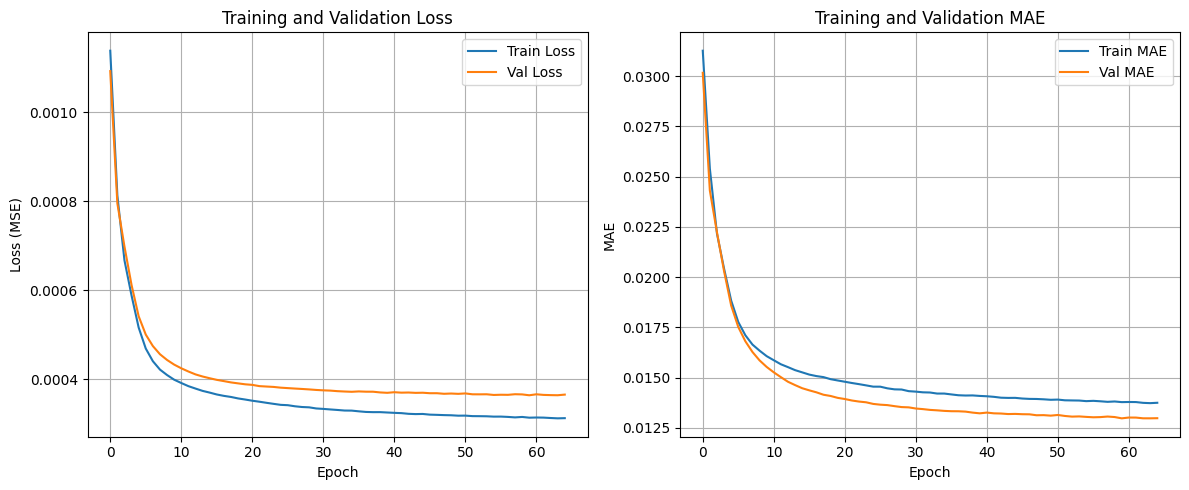

In [ ]:
history_dict = history.history

# Plot loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history_dict['mae'], label='Train MAE')
plt.plot(history_dict['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
def step_rse_corr(y_true, y_pred, step):
    yt = y_true[:, :step, :].reshape(-1)
    yp = y_pred[:, :step, :].reshape(-1)
    rse = np.sqrt(np.sum((yt - yp) ** 2) / (np.sum((yt - np.mean(yt)) ** 2) + 1e-8))
    corr, _ = pearsonr(yt, yp)
    return rse, corr

In [ ]:
def step_all_metrics(y_true, y_pred, step):
    yt = y_true[:, :step, :].reshape(-1)
    yp = y_pred[:, :step, :].reshape(-1)

    mse = mean_squared_error(yt, yp)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(yt, yp)
    r2 = r2_score(yt, yp)
    smape = 100 * np.mean(2 * np.abs(yt - yp) / (np.abs(yt) + np.abs(yp) + 1e-8))
    rse = np.sqrt(np.sum((yt - yp)**2) / (np.sum((yt - np.mean(yt))**2) + 1e-8))
    corr, _ = pearsonr(yt, yp)

    return {
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae,
        'MSE': mse,
        'SMAPE': smape,
        'RSE': rse,
        'CORR': corr
    }

In [ ]:
# Collect y_test from the test_dataset
y_test = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)


In [ ]:
y_pred = model.predict(test_dataset)

212/212 ━━━━━━━━━━━━━━━━━━━━ 24s 111ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


In [ ]:
print(f'Model Name: Patched TalNet')
for step in [3, 6, 12, 24]:
    m = step_all_metrics(y_test, y_pred, step)
    print(f"Step {step:2d} --> R²={m['R2']:.4f}, RMSE={m['RMSE']:.4f}, MAE={m['MAE']:.4f}, "
          f"MSE={m['MSE']:.4f}, SMAPE={m['SMAPE']:.2f}%, RSE={m['RSE']:.4f}, CORR={m['CORR']:.4f}")


Model Name: Patched TalNet
Step  3 --> R²=0.7811, RMSE=0.0264, MAE=0.0127, MSE=0.0007, SMAPE=30.40%, RSE=0.4679, CORR=0.8838
Step  6 --> R²=0.7789, RMSE=0.0265, MAE=0.0127, MSE=0.0007, SMAPE=30.16%, RSE=0.4702, CORR=0.8826
Step 12 --> R²=0.7754, RMSE=0.0267, MAE=0.0128, MSE=0.0007, SMAPE=30.02%, RSE=0.4740, CORR=0.8805
Step 24 --> R²=0.7705, RMSE=0.0270, MAE=0.0130, MSE=0.0007, SMAPE=30.08%, RSE=0.4791, CORR=0.8774


## Plots after model train

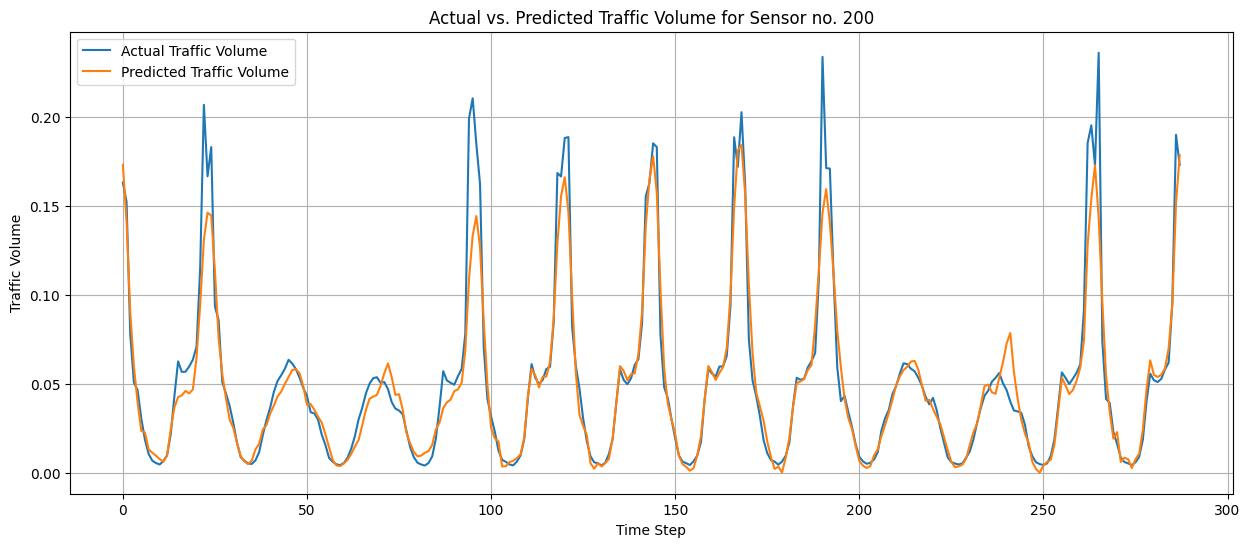

In [ ]:
# Actual Vs Predicted Traffic volume Curve

sample_node = 200
sample_time_steps = 288

plt.figure(figsize=(15, 6))
plt.plot(y_test[:sample_time_steps, 0, sample_node], label='Actual Traffic Volume')
plt.plot(y_pred[:sample_time_steps, 0, sample_node], label='Predicted Traffic Volume')
plt.title(f'Actual vs. Predicted Traffic Volume for Sensor no. {sample_node}')
plt.xlabel('Time Step')
plt.ylabel('Traffic Volume')
plt.legend()
plt.grid(True)
plt.show()

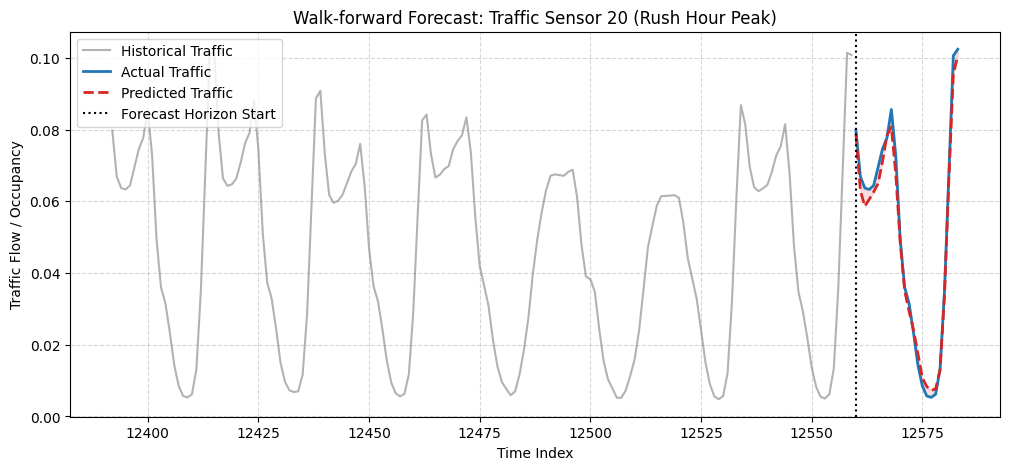

In [ ]:
# Walk-forward Forecast

sensor_idx = 20
peak_window_idx = np.argmax(np.max(y_test[:, :, sensor_idx], axis=1))

context_start = peak_window_idx
context_end = peak_window_idx + window_size
forecast_start = context_end
forecast_end = context_end + forecast_horizon

plt.figure(figsize=(12, 5))

plt.plot(df_test.index[context_start:context_end],
         df_test.iloc[context_start:context_end, sensor_idx],
         label='Historical Traffic', color='gray', alpha=0.6)

forecast_index = df_test.index[forecast_start:forecast_end]
actual_vals = y_test[peak_window_idx, :, sensor_idx].flatten()
pred_vals = y_pred[peak_window_idx, :, sensor_idx].flatten()

plt.plot(forecast_index, actual_vals, label='Actual Traffic', color='tab:blue', linewidth=2)
plt.plot(forecast_index, pred_vals, label='Predicted Traffic', color='tab:red', linestyle='--', linewidth=2)

plt.axvline(x=df_test.index[forecast_start], color='black', linestyle=':', label='Forecast Horizon Start')
plt.fill_between(forecast_index, actual_vals, pred_vals, color='tab:red', alpha=0.15)

plt.title(f'Walk-forward Forecast: Traffic Sensor {sensor_idx} (Rush Hour Peak)')
plt.xlabel('Time Index')
plt.ylabel('Traffic Flow / Occupancy')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

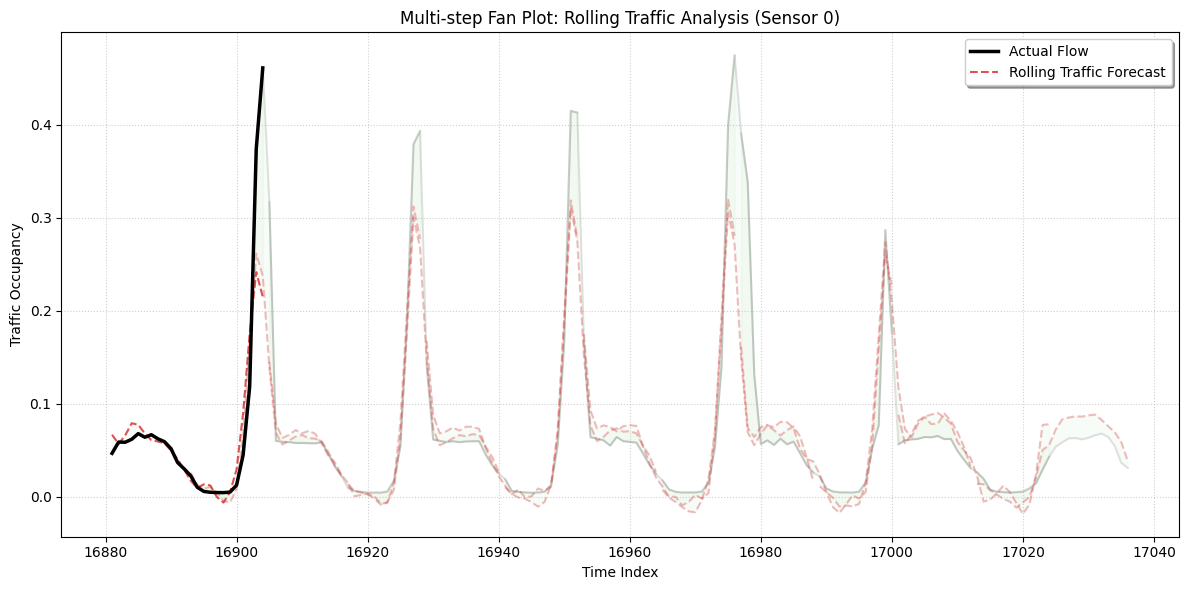

In [ ]:
# Multi-step Fan Plot

sensor_idx = 0
n_forecasts = 12
step_size = forecast_horizon // 2

plt.figure(figsize=(12, 6))

start_offset = np.argmax(np.max(y_test[:, :, sensor_idx], axis=1)) - (n_forecasts * step_size // 2)

for i in range(n_forecasts):
    win_idx = start_offset + (i * step_size)

    forecast_idx = df_test.index[win_idx + window_size : win_idx + window_size + forecast_horizon]
    actual_vals = y_test[win_idx, :, sensor_idx].flatten()
    pred_vals = y_pred[win_idx, :, sensor_idx].flatten()

    if i == 0:
        plt.plot(forecast_idx, actual_vals, color='black', linewidth=2.5, label='Actual Flow', zorder=10)
        plt.plot(forecast_idx, pred_vals, color='tab:red', alpha=0.8, linestyle='--', label='Rolling Traffic Forecast', zorder=5)
    else:
        plt.plot(forecast_idx, actual_vals, color='black', linewidth=1.5, alpha=0.1, zorder=1)
        plt.plot(forecast_idx, pred_vals, color='tab:red', alpha=0.3, linestyle='--', zorder=5)

    plt.fill_between(forecast_idx, actual_vals, pred_vals, color='tab:green', alpha=0.03)

plt.title(f'Multi-step Fan Plot: Rolling Traffic Analysis (Sensor {sensor_idx})')
plt.xlabel('Time Index')
plt.ylabel('Traffic Occupancy')
plt.legend(loc='upper right', frameon=True, shadow=True)
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

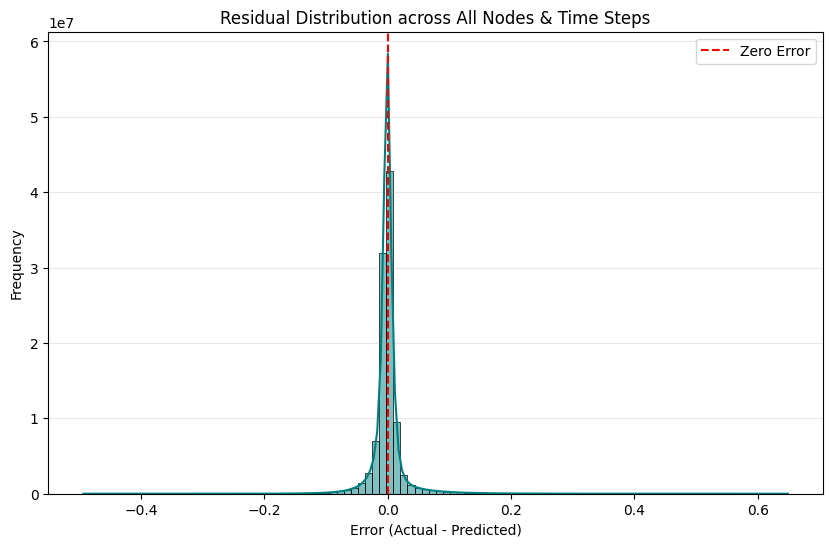

Mean Residual: -0.0000
Residual Std Dev: 0.0270


In [ ]:
# Residual Distribution

residuals = (y_test - y_pred).flatten()
plt.figure(figsize=(10, 6))

# Plotting the distribution with a Kernel Density Estimate (KDE)
sns.histplot(residuals, kde=True, color='teal', bins=100)

# Add a vertical line at 0 to show the perfect prediction center
plt.axvline(x=0, color='red', linestyle='--', linewidth=1.5, label='Zero Error')

plt.title('Residual Distribution across All Nodes & Time Steps')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# Print basic residual statistics
print(f"Mean Residual: {np.mean(residuals):.4f}")
print(f"Residual Std Dev: {np.std(residuals):.4f}")

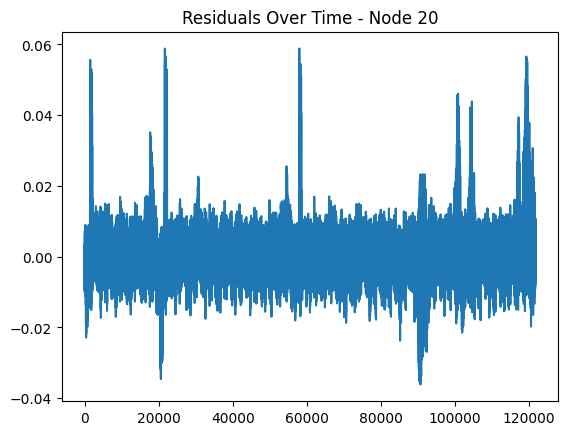

In [ ]:
# Residuals Over Time

residuals = y_test - y_pred
plt.plot(residuals[:, :, 20].flatten())
plt.title('Residuals Over Time - Node 20')
plt.show()

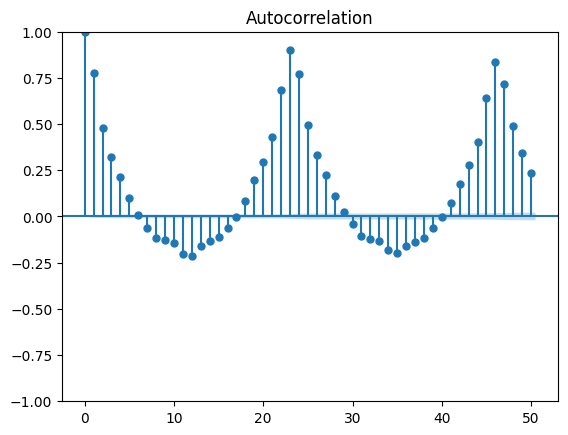

In [ ]:
# Residual Autocorrelation

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals[:, :, 20].flatten(), lags=50)
plt.show()

# Model Saving

In [ ]:
# model.save('/content/drive/MyDrive/data/varsity/traffic_biLSTM.keras')
model.save('/content/drive/MyDrive/data/varsity/TelNetV2_traffic.keras')

In [ ]:
save_dir = "/content/drive/MyDrive/data/varsity/PatchedTalNet_traffic.keras"
model = tf.keras.models.load_model(save_dir, compile=False)
print("Model loaded successfully")

Model loaded successfully


# model loading with fix

In [ ]:
keras_path = "/content/drive/MyDrive/data/varsity/TelNetV2_traffic.keras"
extract_dir = "/content/extracted_model"

with zipfile.ZipFile(keras_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction complete.")
print("Contents:", os.listdir(extract_dir))

Extraction complete.
Contents: ['model.weights.h5', 'config.json', 'metadata.json']


In [ ]:
model = PatchedTalNet(
    n_nodes=n_nodes,
    horizon=forecast_horizon,
    patch_len=16,
    patch_stride=8,
    d_model=64,
    n_heads=4,
    n_stack=2,
    dropout_rate=0.2
)

dummy = tf.random.normal((1, 168, 862))
_ = model(dummy)

print("Model built.")

Model built.


In [ ]:
weights_path = os.path.join(extract_dir, "model.weights.h5")

model.load_weights(weights_path)

print("Weights restored successfully.")

Weights restored successfully.


In [ ]:
save_dir = "/content/drive/MyDrive/data/varsity/PatchedTalNet_traffic.keras"
model.save(save_dir)  # saves in SavedModel format
print(f"Model saved successfully at {save_dir}")

Model saved successfully at /content/drive/MyDrive/data/varsity/PatchedTalNet_traffic.keras


In [ ]:
loaded_model = tf.keras.models.load_model(save_dir, compile=False)
print("Model loaded successfully")

Model loaded successfully
